In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

# --- 1. MOCK DATA GENERATION (Simulating Istanbul Coordinates) ---
# In a real-world scenario, we would use gpd.read_file() here.

def generate_random_points(n, center_lat, center_lon, radius=0.1):
    """
    Generates random points around a central coordinate.
    """
    lats = np.random.uniform(center_lat - radius, center_lat + radius, n)
    lons = np.random.uniform(center_lon - radius, center_lon + radius, n)
    return [Point(xy) for xy in zip(lons, lats)]

# Istanbul Center Coordinates (Approximate)
center_lat, center_lon = 41.0082, 28.9784

# Generate 50 Hospital locations
hospital_geom = generate_random_points(50, center_lat, center_lon)
hospital_gdf = gpd.GeoDataFrame(geometry=hospital_geom, crs="EPSG:4326")
hospital_gdf['name'] = [f"Hospital {i+1}" for i in range(50)]

# Generate 10 Analysis Points (e.g., Residential areas or potential house locations)
locations_geom = generate_random_points(10, center_lat, center_lon)
locations_gdf = gpd.GeoDataFrame(geometry=locations_geom, crs="EPSG:4326")
locations_gdf['location_id'] = range(10)

print("Mock data generated successfully!")
print(f"Total Hospital: {len(hospital_gdf)}")
print(f"Total Analysis Points: {len(locations_gdf)}")

Mock data generated successfully!
Total Hospital: 50
Total Analysis Points: 10


In [2]:
# --- 2. SPATIAL ANALAYSIS ---

# Reprojecting to a metric CRS for accurate distance calculations.
# EPSG:4326 is in degrees (Lat/Lon)
# EPSG:32635 is UTM Zone 35N (meters), suitable for Istanbul/Türkiye.
hospitals_meter = hospital_gdf.to_crs("EPSG:32635")
locations_meter = locations_gdf.to_crs("EPSG:32635")

def count_hospitals_nearby(location_point, hospital_gdf, radius_meters):
    """
    Creates a buffer around a point and counts how many hospital points fall within it.
    """
    # Create a buffer area (circle) around the point
    buffer_area = location_point.buffer(radius_meters)
    
    # Count intersections
    count = 0
    for hosp_point in hospital_gdf.geometry:
        if buffer_area.contains(hosp_point):
            count += 1
    return count

# Copy original GDF to store results
analysis_results = locations_gdf.copy()

# Analyze for 1km (1000m), 2km, and 3km
radii = [1000, 2000, 3000]

for dist in radii:
    col_name = f'hospitals_within_{dist//1000}km'
    # Apply the function to each geometry in the dataframe
    analysis_results[col_name] = locations_meter.geometry.apply(
        lambda x: count_hospitals_nearby(x, hospitals_meter, dist)
    )
    
# Display the first few rows of the results
print(analysis_results.head())

                    geometry  location_id  hospitals_within_1km  \
0  POINT (28.91821 41.10492)            0                     1   
1  POINT (28.95152 41.10157)            1                     2   
2  POINT (29.07039 41.03756)            2                     0   
3   POINT (28.95456 41.0263)            3                     0   
4  POINT (28.95046 40.94077)            4                     2   

   hospitals_within_2km  hospitals_within_3km  
0                     5                     9  
1                     5                     7  
2                     3                     4  
3                     1                     3  
4                     2                     4  


In [3]:
# --- 3. VISUALIZATIONS ---

# Initialize a map centered on Istanbul
m = folium.Map(location=[41.0082, 28.9784], zoom_start=12, tiles="CartoDB positron")

# A. Add Heatmap for Hospital Density
# Heatmap requires data in [Lat, Lon] format
heat_data = [[point.y, point.x] for point in hospital_gdf.geometry]
HeatMap(heat_data, radius=15, blur=10).add_to(m)

# B. Add Hospital as Blue Circle Markers
for idx, row in hospital_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        popup=row['name']
    ).add_to(m)
    
# C. Add Analysis Points (Locations) with Results in Popup
for idx, row in analysis_results.iterrows():
    # formatting the popup text with HTML
    popup_text = f"""
    <div style="font-family: sans-serif;">
        <b>Location ID:</b> {row['location_id']}<br>
        <hr>
        <b>1km Radius:</b> {row['hospitals_within_1km']} hospitals<br>
        <b>2km Radius:</b> {row['hospitals_within_2km']} hospitals<br>
        <b>3km Radius:</b> {row['hospitals_within_3km']} hospitals
    </div>
    """
    
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='red', icon='home'),
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Save the map as an HTML file
output_file = "index.html"
m.save(output_file)

print(f"Map saved as {output_file}. Open this file in your browser to view.")
m # Displays map in Jupyter Notebook

Map saved as index.html. Open this file in your browser to view.


<AxesSubplot:>

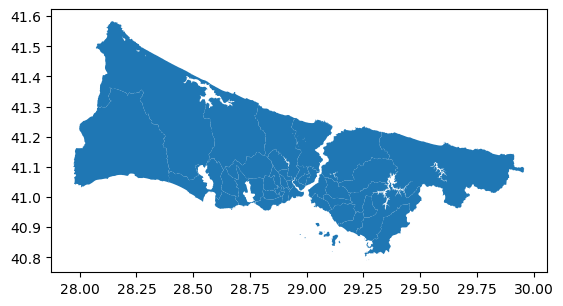

In [4]:
gdf = gpd.read_file("istanbul_ilceler.geojson")
gdf.plot()